# Import Libraries

In [ ]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Reading Dataset

## ADRO

In [ ]:
url_adro = "https://raw.githubusercontent.com/MIlhamEr/Skripsi/refs/heads/main/dataset/PT%20Adaro%20Energy%20Indonesia%20Tbk_2020-2024.csv"
adro = pd.read_csv(url_adro)
adro.head()

Date    Open    High     Low   Close   Adj Close     Volume
0  2020-01-02  1555.0  1555.0  1490.0  1495.0  835.632202   76612000
1  2020-01-03  1460.0  1470.0  1425.0  1465.0  856.372375  117795600
2  2020-01-06  1455.0  1515.0  1450.0  1465.0  856.372375   61423200
3  2020-01-07  1480.0  1540.0  1460.0  1540.0  900.213867   74336500
4  2020-01-08  1530.0  1535.0  1505.0  1505.0  879.754395   55121100

In [ ]:
adro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1148 entries, 0 to 1147
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1148 non-null   object 
 1   Open       1148 non-null   float64
 2   High       1148 non-null   float64
 3   Low        1148 non-null   float64
 4   Close      1148 non-null   float64
 5   Adj Close  1148 non-null   float64
 6   Volume     1148 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 62.9+ KB


## DSSA

In [ ]:
url_dssa = "https://raw.githubusercontent.com/MIlhamEr/Skripsi/refs/heads/main/dataset/PT%20Dian%20Swastatika%20Sentosa%20Tbk_2020-2024.csv"
dssa = pd.read_csv(url_dssa)
dssa.head()

Date    Open    High     Low   Close  Adj Close  Volume
0  2020-01-02  1360.0  1435.0  1360.0  1435.0     1435.0    5000
1  2020-01-03  1435.0  1435.0  1435.0  1435.0     1435.0       0
2  2020-01-06  1437.5  1437.5  1435.0  1435.0     1435.0    3000
3  2020-01-07  1435.0  1435.0  1435.0  1435.0     1435.0       0
4  2020-01-08  1435.0  1435.0  1435.0  1435.0     1435.0       0

In [ ]:
dssa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1148 entries, 0 to 1147
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1148 non-null   object 
 1   Open       1148 non-null   float64
 2   High       1148 non-null   float64
 3   Low        1148 non-null   float64
 4   Close      1148 non-null   float64
 5   Adj Close  1148 non-null   float64
 6   Volume     1148 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 62.9+ KB


# Pre-processing Data

## Normalisasi Data

In [ ]:
scaler = MinMaxScaler()

In [ ]:
def normalize_data(df):
    scaled_df = pd.DataFrame(scaler.fit_transform(df.iloc[:, 1:]), columns=df.columns[1:], index=df.index)
    return scaled_df

In [ ]:
adro_norm = adro.copy()
adro_norm = adro_norm.drop('Volume', axis=1)
adro_norm = normalize_data(adro_norm)
adro_norm.head()

Open      High       Low     Close  Adj Close
0  0.260372  0.247207  0.253602  0.243205   0.129805
1  0.233190  0.223464  0.234870  0.234621   0.135675
2  0.231760  0.236034  0.242075  0.234621   0.135675
3  0.238913  0.243017  0.244957  0.256080   0.148084
4  0.253219  0.241620  0.257925  0.246066   0.142293

In [ ]:
adro = adro.drop('Volume', axis=1)
adro = adro.drop('Date', axis=1)
adro.head()

Open    High     Low   Close   Adj Close
0  1555.0  1555.0  1490.0  1495.0  835.632202
1  1460.0  1470.0  1425.0  1465.0  856.372375
2  1455.0  1515.0  1450.0  1465.0  856.372375
3  1480.0  1540.0  1460.0  1540.0  900.213867
4  1530.0  1535.0  1505.0  1505.0  879.754395

In [ ]:
dssa_norm = dssa.copy()
dssa_norm = dssa_norm.drop('Volume', axis=1)
dssa_norm = normalize_data(dssa_norm)
dssa_norm.head()

Open      High       Low     Close  Adj Close
0  0.010859  0.011743  0.011073  0.012575   0.012575
1  0.012669  0.011743  0.012918  0.012575   0.012575
2  0.012729  0.011800  0.012918  0.012575   0.012575
3  0.012669  0.011743  0.012918  0.012575   0.012575
4  0.012669  0.011743  0.012918  0.012575   0.012575

## Windowing (Time Series Data)

# Bagian Baru

Data look back yaitu adalah data yang biasanya dipakai untuk tipe time series, data ini menjadikan nilai lookback+1 sebagai nilai prediksi , dan data lookbacknya sebagai fitur.Ini berlaku untuk seluruh data, contoh penggambarannya seperti pada gambar diatas

In [ ]:
def prepare_data(df, time_step):
    X, y = [], []
    for i in range(len(df)-time_step):
        t = []
        for j in range(time_step):
            t.append(df.iloc[i + j].values)  # Use all columns for features
        X.append(t)
        y.append(df['High'][i + time_step]) # Predict High price
    return np.array(X), np.array(y)

In [ ]:
time_step = 7
X_adro, y_adro = prepare_data(adro_norm, time_step)

In [ ]:
print(X_adro[1])
print(y_adro[1])

[[0.23319027 0.22346369 0.23487032 0.23462089 0.13567503]
 [0.23175966 0.23603352 0.24207493 0.23462089 0.13567503]
 [0.23891273 0.24301676 0.24495677 0.25608011 0.1480843 ]
 [0.25321888 0.24162011 0.25792507 0.24606581 0.14229328]
 [0.25035765 0.23882682 0.24927954 0.24320458 0.14063873]
 [0.25035765 0.25       0.26080692 0.25894134 0.14973887]
 [0.26895565 0.25837989 0.27233429 0.26323319 0.15222076]]
0.2555865921787709


In [ ]:
X_adro.shape, y_adro.shape

((1141, 7, 5), (1141,))

In [ ]:
X_dssa, y_dssa = prepare_data(dssa_norm, time_step)

## Split data into training and testing sets

In [ ]:
X_train_adro, X_test_adro, y_train_adro, y_test_adro = train_test_split(X_adro, y_adro, test_size=0.2, random_state=42, shuffle=False)
X_train_dssa, X_test_dssa, y_train_dssa, y_test_dssa = train_test_split(X_dssa, y_dssa, test_size=0.2, random_state=42, shuffle=False)

In [ ]:
X_train_adro.shape, X_test_adro.shape, y_train_adro.shape, y_test_adro.shape

((912, 7, 5), (229, 7, 5), (912,), (229,))

# Data Mining

In [ ]:
def create_lstm_model(units):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=(X_train_adro.shape[1], X_train_adro.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(units=units, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))  # Output layer for single prediction (predicted stock price)
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

## Bobot LSTM

In [ ]:
# Create model
lstm_model = create_lstm_model(50)  # Example: 50 LSTM units

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
layer = lstm_model.layers[0]  # Ambil hanya layer pertama
if isinstance(layer, LSTM):
    weights = layer.get_weights()
    # W: Input weights, U: Recurrent weights, b: Bias
    W, U, b = weights[0], weights[1], weights[2]
    units = U.shape[0]  # Jumlah unit LSTM
    columns = ["Open", "High", "Low", "Close", "Adj Close"]
    num_features = len(columns)

    # Memisahkan bobot untuk setiap gate
    W_f, W_i, W_c, W_o = np.split(W, 4, axis=1)
    U_f, U_i, U_c, U_o = np.split(U, 4, axis=1)
    b_f, b_i, b_c, b_o = np.split(b, 4, axis=0)

    print("LSTM Layer 1 Weights Analysis:")
    for i in range(num_features):  # Iterasi sesuai jumlah fitur
        print(f"Feature: {columns[i]}")
        print(f"  Forget Gate W_f[{i}, 0]: {W_f[i, 0]}")
        print(f"  Input Gate W_i[{i}, 0]: {W_i[i, 0]}")
        print(f"  Cell State W_c[{i}, 0]: {W_c[i, 0]}")
        print(f"  Output Gate W_o[{i}, 0]: {W_o[i, 0]}")
        print(f"  Forget Gate U_f[{i}, 0]: {U_f[i, 0]}")
        print(f"  Input Gate U_i[{i}, 0]: {U_i[i, 0]}")
        print(f"  Cell State U_c[{i}, 0]: {U_c[i, 0]}")
        print(f"  Output Gate U_o[{i}, 0]: {U_o[i, 0]}")
        print(f"  Forget Gate b_f[{i}]: {b_f[i]}")
        print(f"  Input Gate b_i[{i}]: {b_i[i]}")
        print(f"  Cell State b_c[{i}]: {b_c[i]}")
        print(f"  Output Gate b_o[{i}]: {b_o[i]}")
        print("====")

LSTM Layer 1 Weights Analysis:
Feature: Open
  Forget Gate W_f[0, 0]: -0.04256738722324371
  Input Gate W_i[0, 0]: -0.010287865996360779
  Cell State W_c[0, 0]: -0.05227087438106537
  Output Gate W_o[0, 0]: -0.08412709832191467
  Forget Gate U_f[0, 0]: 0.04162132740020752
  Input Gate U_i[0, 0]: -0.012287689372897148
  Cell State U_c[0, 0]: -0.011030183173716068
  Output Gate U_o[0, 0]: 0.03395417705178261
  Forget Gate b_f[0]: 0.0
  Input Gate b_i[0]: 1.0
  Cell State b_c[0]: 0.0
  Output Gate b_o[0]: 0.0
====
Feature: High
  Forget Gate W_f[1, 0]: 0.06724417209625244
  Input Gate W_i[1, 0]: 0.0061102211475372314
  Cell State W_c[1, 0]: 0.16968616843223572
  Output Gate W_o[1, 0]: 0.05730287730693817
  Forget Gate U_f[1, 0]: 0.09096574783325195
  Input Gate U_i[1, 0]: 0.009209300391376019
  Cell State U_c[1, 0]: 0.04923269897699356
  Output Gate U_o[1, 0]: -0.08389423787593842
  Forget Gate b_f[1]: 0.0
  Input Gate b_i[1]: 1.0
  Cell State b_c[1]: 0.0
  Output Gate b_o[1]: 0.0
====
Fe

## ADRO

In [ ]:
model_adro = create_lstm_model(100)

start_time = time.time()
model_adro.fit(X_train_adro, y_train_adro, epochs=100, batch_size=32, validation_split=0.1)

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Waktu training: {elapsed_time:.2f} detik")

Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0634 - val_loss: 0.0047
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0045 - val_loss: 0.0021
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0025 - val_loss: 0.0016
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0025 - val_loss: 8.3777e-04
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0023 - val_loss: 0.0014
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0026 - val_loss: 8.2497e-04
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0024 - val_loss: 0.0016
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0022 - val_loss: 0.0010
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0024 - val_loss: 0.0012
Epoch 10/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0020 - val_loss: 0.0011
Epoch 11/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0019 - val_loss: 7.9596e-04
Epoch 12/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
model_adro.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 7, 100)         │        42,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 7, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 368,705 (1.41 MB)

 Trainable params: 122,901 (480.08 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 245,804 (960.18 KB)

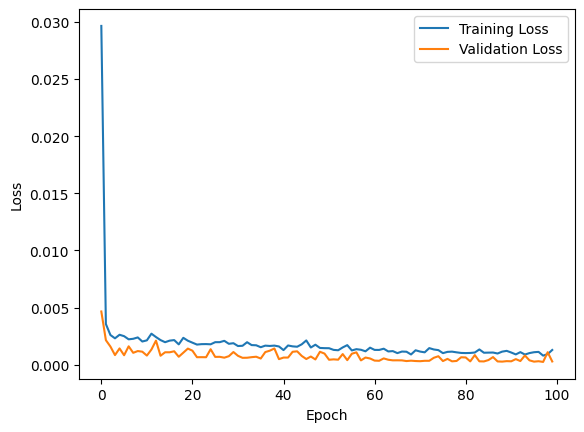

In [ ]:
plt.plot(model_adro.history.history['loss'], label='Training Loss')
plt.plot(model_adro.history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

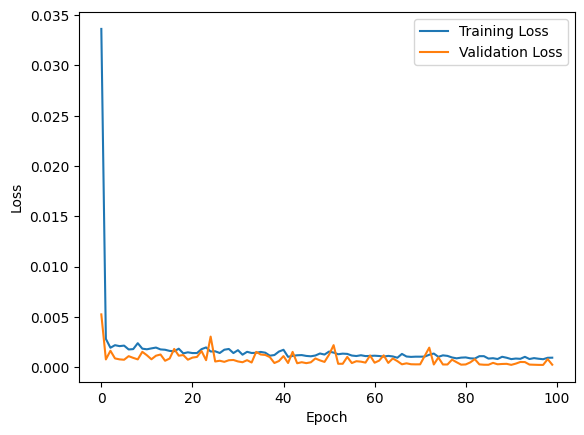

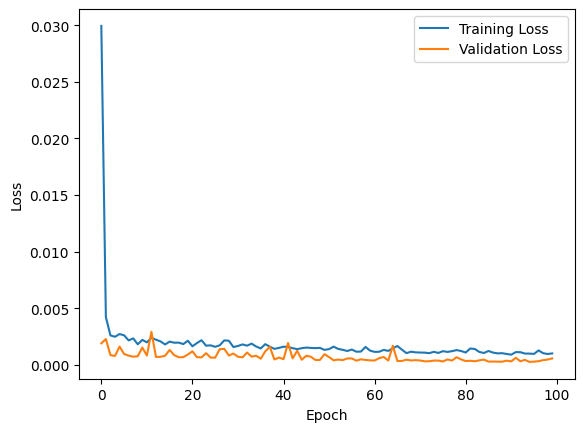

### Make predictions

In [ ]:
y_pred_adro = model_adro.predict(X_test_adro)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step


## DSSA

In [ ]:
model_dssa = create_lstm_model(100)

start_time = time.time()
model_dssa.fit(X_train_dssa, y_train_dssa, epochs=100, batch_size=32, validation_split=0.1)

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Waktu training: {elapsed_time:.2f} detik")

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 6.0729e-04 - val_loss: 1.1607e-04
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 5.3662e-05 - val_loss: 4.0032e-05
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 4.7505e-05 - val_loss: 4.6214e-05
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 3.9637e-05 - val_loss: 2.3383e-05
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 3.3811e-05 - val_loss: 3.4817e-05
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 4.1101e-05 - val_loss: 2.0400e-05
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 4.3098e-05 - val_loss: 2.6784e-05
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 3.4498e-05 - val_loss: 2.7796e-05
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 3.6598e-05 - val_loss: 1.9876e-05
Epoch 10/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 2.5330e-05 - val_loss: 2.1431e-05
Epoch 11/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 3.2087e-05

In [ ]:
model_dssa.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 7, 100)         │        42,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 7, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 368,705 (1.41 MB)

 Trainable params: 122,901 (480.08 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 245,804 (960.18 KB)

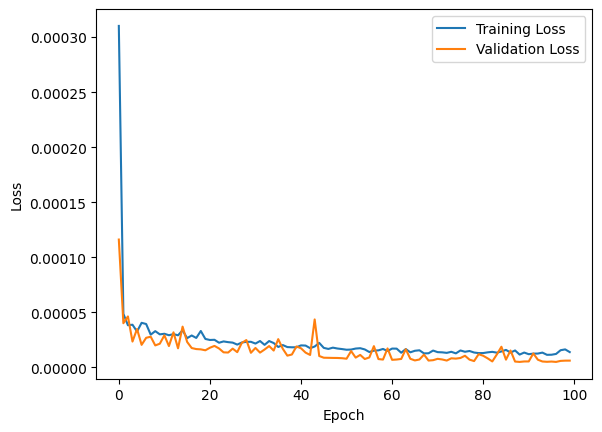

In [ ]:
plt.plot(model_dssa.history.history['loss'], label='Training Loss')
plt.plot(model_dssa.history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Make predictions

In [ ]:
y_pred_dssa = model_dssa.predict(X_test_dssa)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step


## Evaluate Model

In [ ]:
def evaluate_model(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)

    print(f'RMSE: {rmse:.3f}')
    print(f'MAPE: {mape:.3f}%')
    print(f'R-squared: {r2:.5f}')

    return rmse, mape, r2

In [ ]:
# Evaluate ADRO model
print("Evaluation for ADRO:")
rmse_adro, mape_adro, r2_adro = evaluate_model(y_test_adro, y_pred_adro)

# Evaluate DSSA model
print("\nEvaluation for DSSA:")
rmse_dssa, mape_dssa, r2_dssa = evaluate_model(y_test_dssa, y_pred_dssa)

Evaluation for ADRO:
RMSE: 0.023
MAPE: 17.053%
R-squared: 0.95269

Evaluation for DSSA:
RMSE: 0.039
MAPE: 115.017%
R-squared: 0.98061


## Invert

### ADRO

In [ ]:
dummy_input_adro = np.zeros((len(y_pred_adro), 5))
dummy_input_adro[:, 1] = y_pred_adro.reshape(-1)
dummy_input_adro

array([[0.        , 0.59014332, 0.        , 0.        , 0.        ],
       [0.        , 0.58159274, 0.        , 0.        , 0.        ],
       [0.        , 0.57574308, 0.        , 0.        , 0.        ],
       ...,
       [0.        , 0.83483815, 0.        , 0.        , 0.        ],
       [0.        , 0.83351439, 0.        , 0.        , 0.        ],
       [0.        , 0.84000373, 0.        , 0.        , 0.        ]])

In [ ]:
inverted_adro = scaler.inverse_transform(dummy_input_adro)
pred_lstm_adro_real = inverted_adro[:, 1]
pred_lstm_adro_real = pred_lstm_adro_real / 10
pred_lstm_adro_real

array([2680.07354277, 2642.57495525, 2616.92127377, 2638.38320628,
       2654.42325944, 2690.1174292 , 2721.12554982, 2716.84989268,
       2641.32548156, 2570.72917244, 2545.21690628, 2524.19882447,
       2517.85735339, 2466.04549581, 2412.92796436, 2326.40661639,
       2262.77207145, 2275.22916731, 2328.40446731, 2325.6828104 ,
       2301.24540529, 2299.76616436, 2308.28428134, 2317.1040495 ,
       2323.23065293, 2350.15837935, 2362.01243424, 2374.73197186,
       2393.75298694, 2426.76209524, 2450.35806608, 2439.61180815,
       2416.07883379, 2412.01647592, 2428.26982835, 2440.12623581,
       2460.3546398 , 2458.20334932, 2444.28374189, 2406.72451046,
       2383.36405757, 2385.54906815, 2408.55193108, 2420.69718131,
       2415.10513306, 2355.35911754, 2327.67255804, 2344.74721724,
       2354.43717325, 2415.23400137, 2450.51176703, 2462.91762924,
       2463.88740903, 2464.49437094, 2455.53397164, 2336.17368427,
       2299.094899  , 2273.11342672, 2276.10040075, 2287.42225

### DSSA

In [ ]:
dummy_input_dssa = np.zeros((len(y_pred_dssa), 5))
dummy_input_dssa[:, 1] = y_pred_dssa.reshape(-1)
dummy_input_dssa

array([[0.        , 0.09492499, 0.        , 0.        , 0.        ],
       [0.        , 0.09493433, 0.        , 0.        , 0.        ],
       [0.        , 0.09503628, 0.        , 0.        , 0.        ],
       ...,
       [0.        , 0.86946911, 0.        , 0.        , 0.        ],
       [0.        , 0.8616249 , 0.        , 0.        , 0.        ],
       [0.        , 0.87051117, 0.        , 0.        , 0.        ]])

In [ ]:
inverted_dssa = scaler.inverse_transform(dummy_input_dssa)
pred_lstm_dssa_real = inverted_dssa[:, 1]
pred_lstm_dssa_real

array([ 5082.93527693,  5083.34501542,  5087.81587016,  5089.03168909,
        5070.51046349,  5085.22804808,  5060.38038168,  4971.20083071,
        4949.66178633,  4949.40039016,  4956.51494041,  4960.5077669 ,
        4998.44451975,  5007.93875538,  5042.28523184,  5056.97112214,
        5057.96344735,  5056.33690968,  5055.07828712,  4972.53362443,
        4951.61768317,  5033.10499836,  5056.30488865,  5058.93649459,
        5063.1773207 ,  5057.11587027,  5054.88027953,  5095.43720223,
        5105.8770385 ,  5106.34199694,  5105.13794083,  5104.13515978,
        5103.68163742,  5103.53460208,  5103.53460208,  5103.53460208,
        5103.53460208,  5103.53460208,  5103.53460208,  5103.53460208,
        5103.53460208,  5103.53460208,  5103.53460208,  5619.75021377,
        6542.94397786,  7578.27408478,  8144.0739359 ,  8115.44190645,
        7991.30290501,  7802.81862244,  7816.77587092,  7867.07633585,
        7879.92657155,  7885.57664976,  7885.12966231,  7884.10172187,
      

### Simpan Prediksi

In [ ]:
adro_actual = adro['High'].iloc[919:]
dssa_actual = dssa['High'].iloc[919:]

In [ ]:
# Create dataframes for predictions
df_pred_adro = pd.DataFrame({'Actual ADRO': adro_actual.values, 'Predicted ADRO': pred_lstm_adro_real.flatten()})
df_pred_dssa = pd.DataFrame({'Actual DSSA': dssa_actual.values, 'Predicted DSSA': pred_lstm_dssa_real.flatten()})

In [ ]:
# Save predictions to CSV files
df_pred_adro.to_csv('LSTM_adro_predictions.csv', index=False)
df_pred_dssa.to_csv('LSTM_dssa_predictions.csv', index=False)

print("ADRO predictions saved to 'LSTM_adro_predictions.csv'")
print("DSSA predictions saved to 'LSTM_dssa_predictions.csv'")

ADRO predictions saved to 'LSTM_adro_predictions.csv'
DSSA predictions saved to 'LSTM_dssa_predictions.csv'


In [ ]:
# prompt: downloadkan csv adro dan dssa tersebut

from google.colab import files

files.download('LSTM_adro_predictions.csv')
files.download('LSTM_dssa_predictions.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>